# U-Net para Segmentação de Imagens

Este notebook ilustra como construir uma [UNet](https://arxiv.org/abs/1505.04597) para segmentação semântica de imagens. Essa arquitetura também é uma rede totalmente convolucional e é semelhante ao modelo que você acabou de criar na lição anterior. Uma diferença importante é o uso de conexões de salto (*skip connections*) do codificador para o decodificador. Você verá como isso é implementado mais tarde, ao criar cada parte da rede.

Ao final deste laboratório, você poderá usar a UNet para gerar máscaras de segmentação que mostram quais pixels de uma imagem de entrada fazem parte do plano de fundo, do primeiro plano e do contorno.

<img src='https://drive.google.com/uc?export=view&id=1w8up90xVOYRT8vs5lNo2kEiVhm-7hWxZ' alt='sample_output'>

# Importações

In [1]:
try:
  # %tensorflow_version só existe no Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Faça o download do conjunto de dados Oxford-IIIT Pets

Você treinará o modelo no conjunto de dados [Oxford Pets - IIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Ele contém imagens de animais de estimação, suas classes, máscaras de segmentação e região de interesse da cabeça. Você só usará as imagens e as máscaras de segmentação neste laboratório.

Esse conjunto de dados já está incluído no TensorFlow Datasets e você pode simplesmente baixá-lo. A célula abaixo fará o download do conjunto de dados e colocará os resultados em um dicionário chamado `dataset`. Ela também coletará informações sobre o conjunto de dados e as atribuirá a uma variável chamada `info`.

In [2]:
# Se você tiver um problema com os checksums, poderá executar a seguinte linha primeiro
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# Faça o download do dataset e obtenha informações
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

W0620 12:28:44.277174 140544010299200 download_and_prepare.py:46] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset oxford_iiit_pet:3.1.0 from imports: tensorflow_datasets.datasets.oxford_iiit_pet.oxford_iiit_pet_dataset_builder
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 59, in <module>
    app.run(main, flags_parser=_parse_flags)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/download_and_prepa

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteA9KIOM/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteA9KIOM/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Vamos examinar brevemente o conteúdo do conjunto de dados que você acabou de baixar.

In [3]:
# veja as possíveis chaves que podemos acessar no dict do dataset.
# ele contém as divisões de teste e treinamento.
print(dataset.keys())

dict_keys(['train', 'test'])


In [4]:
# veja abaixo informação sobre o dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmp5ljqw02vtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

## Prepara o Dataset

Agora você preparará os conjuntos de treino e teste. As seguintes funções utilitárias pré-processam os dados. Elas incluem:

* Aumento simples, invertendo a imagem
* normalização dos valores de pixel
* redimensionamento das imagens

Outra etapa de pré-processamento é ajustar os valores de pixel da máscara de segmentação. O `README` na pasta [annotations](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz) do dataset menciona que os pixels na máscara de segmentação são rotulados como tal:

| Rótulo           | Nome da Classe |
| -------------    | -------------  |
| 1                | foreground     |
| 2                | background     |
| 3                | Não Classificado |

<br>
<br>

Por conveniência, vamos subtrair `1` desses valores e os interpretaremos como `{'pet', 'background', 'outline'}`:

| Rótulo            | Nome da Classe     |
| -------------    | -------------  |
| 0                | pet            |
| 1                | background     |
| 2                | outline        |

In [5]:
# Utilitários de Pré-processamento

def random_flip(input_image, input_mask):
  '''faz uma inversão aleatória da imagem e da máscara'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  '''
  normaliza os valores de pixel da imagem de entrada para que sejam de [0,1].
  subtrai 1 dos rótulos da máscara para ter um intervalo de [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''redimensiona, normaliza e inverte os dados de treinamento'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(datapoint):
  '''redimensiona e normaliza os dados de teste'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Agora você pode chamar as funções do utilitário acima para preparar os conjuntos de treino e teste. O conjunto de dados que você baixou do TFDS já contém essas divisões e você as usará simplesmente acessando as chaves `train` e `test` do dicionário `dataset`.

*Nota*: O `tf.data.experimental.AUTOTUNE` que você vê neste notebook é simplesmente uma constante igual a `-1`. Esse valor é passado para permitir que determinados métodos definam automaticamente os parâmetros com base nos recursos disponíveis. Por exemplo, o parâmetro `num_parallel_calls` abaixo será definido dinamicamente com base nas CPUs disponíveis. A documentação mostrará se um parâmetro pode ser ajustado automaticamente. [Aqui](https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/data/ops/dataset_ops.py#L1557-L1702) é a entrada que descreve o que ele faz com `num_parallel_calls`.

In [6]:
# pré-processar os conjuntos de treino e teste
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

Agora que as divisões estão carregadas, você pode preparar lotes para treino e teste.

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# embaralhar e agrupar o conjunto de treino em lotes
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# fazer uma pré-busca para otimizar o processamento
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# agrupar o conjunto de testes em lotes
test_dataset = test.batch(BATCH_SIZE)

Vamos definir mais alguns utilitários para nos ajudar a visualizar nossos dados e métricas.

In [8]:
# lista de classes dos pixels da máscara
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''exibe uma lista de imagens/máscaras e sobrepõe uma lista de IOU e Dice Scores'''

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Máscara Predita", "Máscara Real"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
  '''exibe uma lista de imagens/máscaras'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()


def show_image_from_dataset(dataset):
  '''exibe a primeira imagem e sua máscara de um dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plota uma determinada métrica do histórico do modelo'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

Por fim, você pode dar uma olhada em um exemplo de imagem e sua máscara correspondente do conjunto de dados.

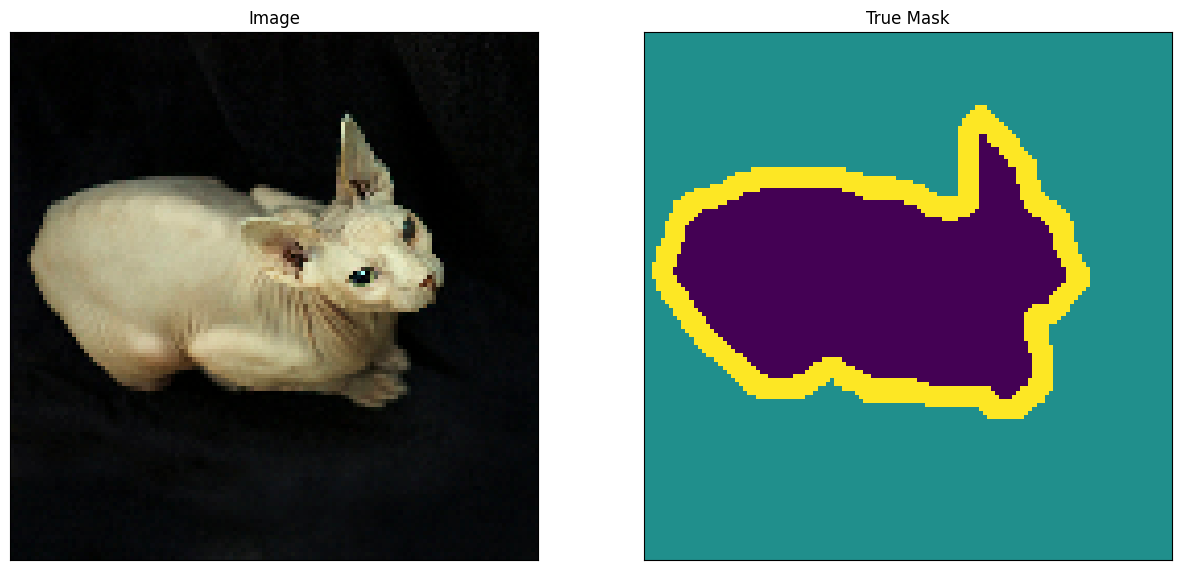

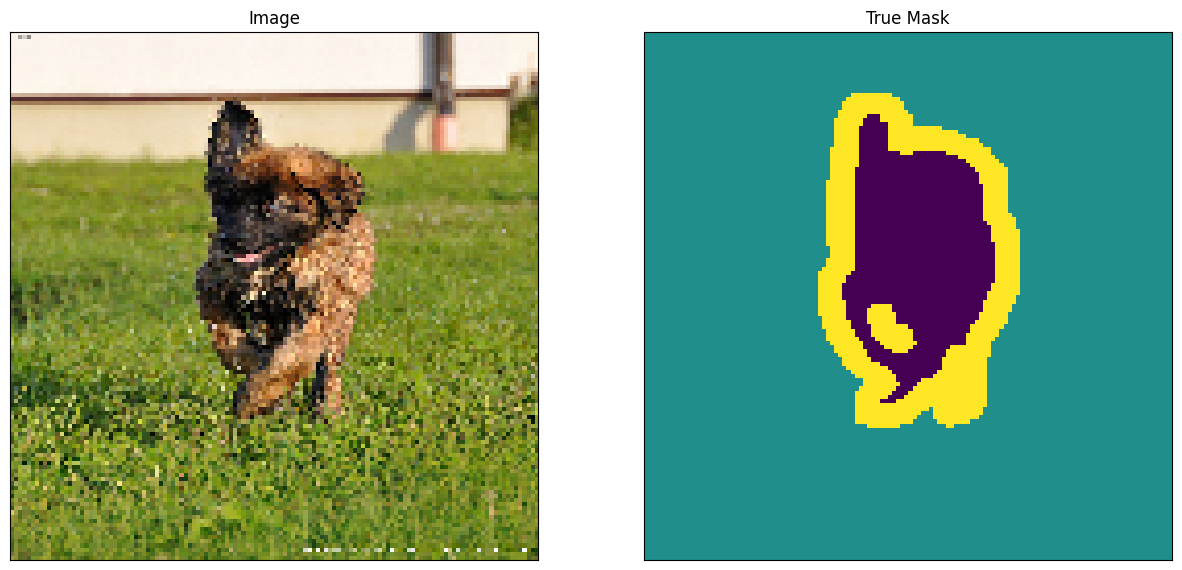

In [9]:
# Exibir uma imagem do conjunto de treino
show_image_from_dataset(train)

# Exibir uma imagem do conjunto de teste
show_image_from_dataset(test)

## Definir o modelo

Com o dataset preparado, agora você pode criar a UNet. Aqui está a arquitetura geral:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

Uma UNet consiste em um codificador (downsampler) e um decodificador (upsampler) com um gargalo no meio. As setas cinza correspondem às conexões de salto que concatenam as saídas do bloco do codificador a cada estágio do decodificador. Vamos ver como implementá-las, começando pelo codificador.

### Codificador

Assim como o modelo FCN que você construiu na lição anterior, o codificador aqui terá blocos repetidos (caixas vermelhas na figura abaixo), portanto, é melhor criar funções para tornar o código modular. Esses blocos do codificador conterão duas camadas Conv2D ativadas por ReLU, seguidas por uma camada MaxPooling e Dropout. Cada estágio terá um número crescente de filtros e a dimensionalidade das características será reduzida devido à camada de pooling.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

Os utilitários do codificador terão três funções:

* `conv2d_block()` - para adicionar duas camadas de convolução e ativações ReLU
* `encoder_block()` - para adicionar pooling e dropout aos blocos conv2d. Lembre-se de que, na UNet, você precisa salvar a saída das camadas de convolução em cada bloco, portanto, essa função retornará dois valores para levar isso em consideração (ou seja, a saída do bloco conv e o dropout)
* `encoder()` - para construir o codificador inteiro. Isso retornará a saída do último bloco do codificador, bem como a saída dos blocos de conv anteriores. Eles serão concatenados aos blocos do decodificador, como você verá mais adiante.

In [11]:
# Utilitários do Encoder

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adiciona 2 camadas convolucionais com os parâmetros passados a ele

  Args:
    input_tensor (tensor) -- o tensor de entrada
    n_filters (int) -- número de filtros
    kernel_size (int) -- tamanho do kernel para a convolução

  Retorna:
    tensor de recursos de saída
  '''  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adiciona dois blocos convolucionais e, em seguida, executa a amostragem descendente na saída das convoluções.

  Args:
    input_tensor (tensor) -- o tensor de entrada
    n_filters (int) -- número de filtros
    kernel_size (int) -- tamanho do kernel para a convolução

  Retorna:
    f - os recursos de saída do bloco de convolução
    p - os recursos maxpooled com dropout
  '''
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  Essa função define o caminho do codificador ou da redução de amostragem.

  Args:
    inputs (tensor) -- lote de imagens de entrada

  Retorna:
    p4 - os recursos maxpooled de saída do último bloco do codificador
    (f1, f2, f3, f4) - os recursos de saída de todos os blocos do codificador
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Gargalo


Um gargalo segue o bloco do codificador e é usado para extrair mais características. Esse bloco não tem uma camada de pooling, portanto a dimensionalidade permanece a mesma. Você pode usar a função `conv2d_block()` definida anteriormente para implementar isso.

In [12]:
def bottleneck(inputs):
  '''
  Essa função define as convoluções de gargalo para extrair mais características antes das camadas de upsampling.
  '''
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

### Decodificador

Por fim, temos o decodificador que faz o upsampling das características de volta ao tamanho original da imagem. Em cada nível de upsampling, você pegará a saída do bloco codificador correspondente e a concatenará antes de alimentar o próximo bloco decodificador. Isso está resumido na figura abaixo.

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [14]:
# Ulitários do Decodificador

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  define o bloco de um decodificador da UNet

  Args:
    inputs (tensor) -- lote de características de entrada
    conv_output (tensor) -- características de um bloco codificador
    n_filters (int) -- número de filtros
    kernel_size (int) -- tamanho do kernel
    strides (int) -- strides para a deconvolução/upsampling
    padding (string) -- "same" ou "valid", informa se a forma será preservada por zero padding

  Retorna:
    c (tensor) -- características de saída do bloco do decodificador
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Define o decodificador da UNet encadeando 4 blocos de decodificador.

  Args:
    inputs (tensor) -- lote de características de entrada
    convs (tuple) -- características dos blocos do codificador
    output_channels (int) -- número de classes no mapa de rótulos

  Retorna:
    outputs (tensor) -- o mapa de rótulos da imagem com base em pixels
  '''
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Juntando tudo

Finalmente, você pode criar a UNet encadeando o codificador, o gargalo e o decodificador. Você especificará o número de canais de saída e, nesse conjunto específico, esse número seria `3`. Isso ocorre porque há três rótulos possíveis para cada pixel: 'pet', 'background' e 'outline'.

In [15]:
OUTPUT_CHANNELS = 3

def unet():
  '''
  Define a UNet conectando o codificador, o gargalo e o decodificador.
  '''
  # especifique a forma de entrada
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # Alimentar as entradas do codificador
  encoder_output, convs = encoder(inputs)

  # Alimentar a saída do codificador para o gargalo
  bottle_neck = bottleneck(encoder_output)

  # Alimentar o gargalo e as saídas do bloco do codificador para o decodificador
  # Especifique o número de classes por meio do argumento `output_channels`.
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # crie o modelo
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instancie model
model = unet()

# visualize a arquitetura resultante
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Compilar e treinar o modelo

Agora, tudo o que resta a fazer é compilar e treinar o modelo. A perda que você usará é `sparse_categorical_crossentropy`. O motivo é que a rede está tentando atribuir um rótulo a cada pixel, assim como a previsão multiclasse. Na máscara de segmentação verdadeira, cada pixel tem {0,1,2}. A rede aqui está produzindo três canais. Essencialmente, cada canal está tentando aprender a prever uma classe e `sparse_categorical_crossentropy` é a perda recomendada para esse cenário.

In [17]:
# Configurar o otimizador, a perda e as métricas para treinamento
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Configure os parâmetros de treinamento e treine o modelo

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# isso levará cerca de 20 minutos para ser executado
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 112s 1s/step - loss: 0.9675 - accuracy: 0.5720 - val_loss: 0.8550 - val_accuracy: 0.5738
Epoch 2/10
57/57 [==============================] - 72s 1s/step - loss: 0.7706 - accuracy: 0.6569 - val_loss: 0.6868 - val_accuracy: 0.7160
Epoch 3/10
57/57 [==============================] - 59s 1s/step - loss: 0.6655 - accuracy: 0.7284 - val_loss: 0.6301 - val_accuracy: 0.7462
Epoch 4/10
57/57 [==============================] - 60s 1s/step - loss: 0.6107 - accuracy: 0.7534 - val_loss: 0.5841 - val_accuracy: 0.7609
Epoch 5/10
57/57 [==============================] - 60s 1s/step - loss: 0.5636 - accuracy: 0.7751 - val_loss: 0.5376 - val_accuracy: 0.7826
Epoch 6/10
57/57 [==============================] - 59s 1s/step - loss: 0.5106 - accuracy: 0.7993 - val_loss: 0.4759 - val_accuracy: 0.8135
Epoch 7/10
57/57 [==============================] - 59s 1s/step - loss: 0.4784 - accuracy: 0.8135 - val_loss: 0.4749 - val_accuracy: 0.8234
Epoch 8/10
57/57 [=

Você pode plotar a perda de treinamento e validação para ver como foi o treinamento. Isso deve mostrar valores geralmente decrescentes por época.

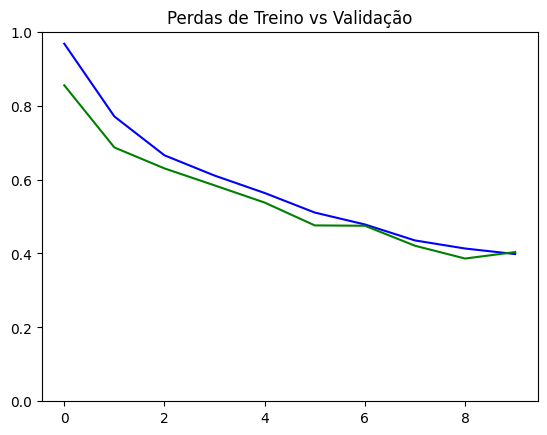

In [19]:
# Plot the training and validation loss
plot_metrics("loss", title="Perdas de Treino vs Validação", ylim=1)

## Faça previsões

O modelo agora está pronto para fazer algumas previsões. Você usará o conjunto de dados de teste que preparou anteriormente para alimentar imagens de entrada que o modelo nunca viu antes. Os utilitários abaixo ajudarão a processar o conjunto de dados de teste e as previsões do modelo.

In [20]:
# Utilitário de Predição

def get_test_image_and_annotation_arrays():
  '''
  Descompacta o conjunto de dados de teste e retorna as imagens de entrada e as máscaras de segmentação
  '''
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  '''
  Cria a máscara de segmentação obtendo o canal com a maior probabilidade. Lembre-se de que temos
  temos 3 canais na saída da UNet. Para cada pixel, a previsão será o canal com a
  maior probabilidade.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Alimenta uma imagem em um modelo e retorna a máscara prevista.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

### Calcular métricas por classe

Como no laboratório anterior, você também deverá calcular o IOU e a pontuação dos dados. Essa é a mesma função que você usou anteriormente.

In [21]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

Com todos os utilitários definidos, agora você pode prosseguir com a exibição das métricas e a alimentação das imagens de teste.

In [22]:
# Configure o ground-truth e as previsões.

# Obter o ground-truth do conjunto de teste
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# alimentar o conjunto de teste com o modelo para obter as máscaras previstas
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 [==============================] - 19s 333ms/step


In [23]:
# calcular as métricas por classe
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [24]:
# Mostrar o IOU para cada classe
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.7077160149629802 
background  0.8342095191278758 
outline     0.37036163068104433 


In [25]:
# monstrar o Dice Score para cada classe
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))


pet         0.8288450875463678 
background  0.9096120267924953 
outline     0.5405312326167232 


### Mostrar Predições

1/1 [==============================] - 1s 1s/step


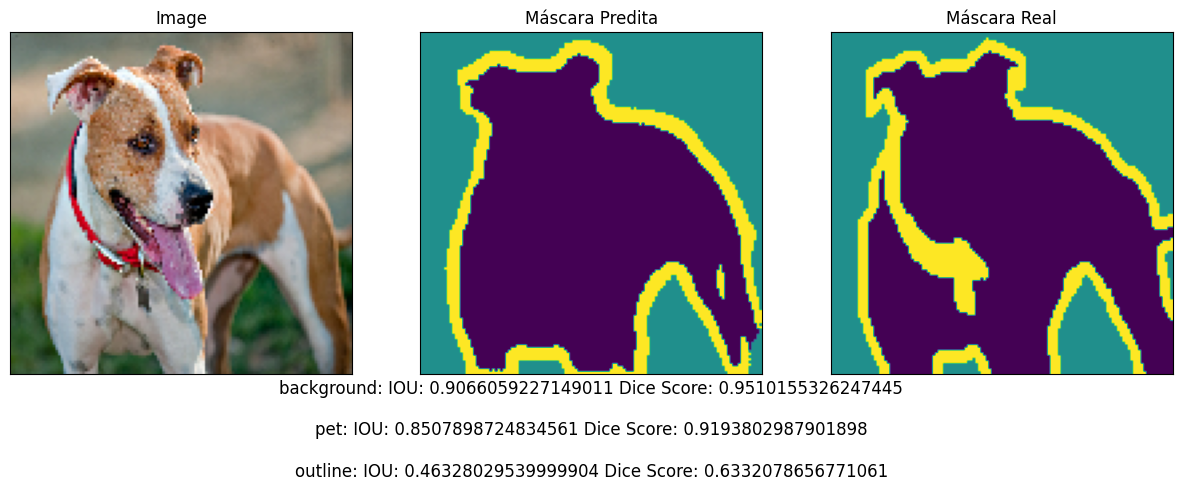

In [26]:
# Insira um número entre 0 e 3647 para escolher uma imagem do conjunto de dados
integer_slider = 3646

# Obter a máscara de predição
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Calcular as métricas por classe
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# Sobrepor as métricas com as imagens
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

**Isso é tudo para este laboratório! No próximo notebook, você aprenderá sobre outro tipo de modelo de segmentação de imagens: Máscara R-CNN para segmentação de instâncias!